/tmp/ipykernel_82604/3730293817.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.resample("D").mean()


Epoch 1, Loss: 0.0764
Epoch 2, Loss: 0.0737
Epoch 3, Loss: 0.0712
Epoch 4, Loss: 0.0688
Epoch 5, Loss: 0.0665
Epoch 6, Loss: 0.0644
Epoch 7, Loss: 0.0624
Epoch 8, Loss: 0.0605
Epoch 9, Loss: 0.0587
Epoch 10, Loss: 0.0569
Epoch 11, Loss: 0.0553
Epoch 12, Loss: 0.0538
Epoch 13, Loss: 0.0524
Epoch 14, Loss: 0.0510
Epoch 15, Loss: 0.0497
Epoch 16, Loss: 0.0485
Epoch 17, Loss: 0.0473
Epoch 18, Loss: 0.0462
Epoch 19, Loss: 0.0452
Epoch 20, Loss: 0.0442
Epoch 21, Loss: 0.0433
Epoch 22, Loss: 0.0424
Epoch 23, Loss: 0.0416
Epoch 24, Loss: 0.0408
Epoch 25, Loss: 0.0401
Epoch 26, Loss: 0.0394
Epoch 27, Loss: 0.0387
Epoch 28, Loss: 0.0381
Epoch 29, Loss: 0.0375
Epoch 30, Loss: 0.0369
Epoch 31, Loss: 0.0364
Epoch 32, Loss: 0.0359
Epoch 33, Loss: 0.0354
Epoch 34, Loss: 0.0350
Epoch 35, Loss: 0.0345
Epoch 36, Loss: 0.0341
Epoch 37, Loss: 0.0338
Epoch 38, Loss: 0.0334
Epoch 39, Loss: 0.0331
Epoch 40, Loss: 0.0327
Epoch 41, Loss: 0.0324
Epoch 42, Loss: 0.0322
Epoch 43, Loss: 0.0319
Epoch 44, Loss: 0.03

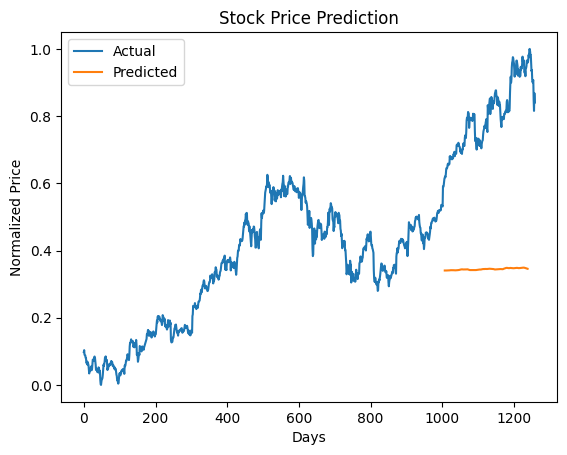

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define hyperparameters
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1
learning_rate = 0.01
num_epochs = 100
window_size = 20

# Load and preprocess data
data = pd.read_csv("../data/all_stocks_5yr.csv")
data = data[data["Name"] == "AAPL"]
data = data[["date", "close"]]
data["Date"] = pd.to_datetime(data["date"])
data = data.set_index("Date")
data = data.resample("D").mean()
data = data.dropna()
data = data.values

# Normalize data using min-max scaling
min_val = np.min(data)
max_val = np.max(data)
data = (data - min_val) / (max_val - min_val)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data = data[:train_size]
test_data = data[train_size:]

# Define a function to create input sequences and corresponding labels from the data
def create_sequences(data, window_size):
    x = []
    y = []
    for i in range(len(data) - window_size):
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
    x = np.array(x)
    y = np.array(y)
    return x, y

# Create input sequences and labels for train and test sets using the defined function
x_train, y_train = create_sequences(train_data, window_size)
x_test, y_test = create_sequences(test_data, window_size)

# Convert numpy arrays to PyTorch tensors and reshape them to match the expected input shape of the model
x_train = torch.from_numpy(x_train).float().view(-1, window_size, input_size)
y_train = torch.from_numpy(y_train).float().view(-1, output_size)
x_test = torch.from_numpy(x_test).float().view(-1, window_size, input_size)
y_test = torch.from_numpy(y_test).float().view(-1, output_size)

# Define the model class as a subclass of nn.Module
class StockModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Create an instance of the model class with the defined hyperparameters
model = StockModel(input_size, hidden_size, num_layers, output_size)

# Define a loss function as the mean squared error (MSE)
criterion = nn.MSELoss()

# Define an optimizer as stochastic gradient descent (SGD) with the defined learning rate
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Test the model
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    print(f"Test Loss: {loss.item():.4f}")

# Plot the actual and predicted stock prices
x_range = np.arange(train_size, len(data))  # Use x_range instead of np.arange(train_size, len(data))
plt.plot(data, label="Actual")
plt.plot(x_range[:len(y_pred)], y_pred.numpy(), label="Predicted")  # Slice x_range to match y_pred length
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Normalized Price")
plt.show()

